# Bayesian Network for classifying the Grades of Portuguese Students
This notebook contains the code for the Bayesian Network calculating the grades of Portuguese students. The Bayesian Network is based on the analysis of the data from the *analyse-data.ipynb* notebook. The Bayesian Network is implemented using the *pgmpy* library and the train data is loaded from the *student-por_2.csv* file in the data folder.

## 0. Install required libraries
This section installs all needed libraries in a python virtual environment which can be used as Jupyter kernel. This needs only to be done once.

In [ ]:
! python -m venv ../.env
! source ../.env/bin/activate
! pip install -r ../requirements.txt

## 1. Import libraries
This section imports all needed libraries and sets the path to the data, number of rows to be displayed.

In [3]:
%reset -f

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator 
from pgmpy.inference import VariableElimination
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score
from sklearn.model_selection import train_test_split

# Self-written modules for better code structure
from helpers.evaluation import MultiClassEvaluation, BinaryEvaluation
from app.preprocessing import TunedPreprocessing, BinaryPreprocessing, BoundOutPutPreprocessing, BinaryOutPutPreprocessing, Preprocessing

# Set pandas options
pd.set_option('display.max_columns', 500)

/home/tom/projects/probability-ki/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Settings

In [4]:
DATA_PATH = "../data/"
RESULT_PATH = "../data/results/"
DOC_PATH = "../doc/"
MODEL_PATH = "../models/"

SAVE_ALL_CPDS = False
SKIP_BIG = False

RANDOM_STATE = 1234
SPLIT = 0.2
NUMBER_CORES = 10 # !IMPORTANT: Set this to the number of cores of your machine for parallelization. It is recommended to use not all cores.

WEIGHTS = False
GAUSSIAN_NOISE = False
REMOVE_OUTLIERS = True

# EMPTY_COLS = [ 'G3']
# EMPTY_COLS = ['G1', 'G3']
# EMPTY_COLS = ['G2', 'G3']
EMPTY_COLS = ['G1', 'G3', 'G2']
# EMPTY_COLS = ['G1', 'G3', 'G2', 'studytime']

## 3. Load and prepare data
For the Bayesian Network we need to load the data from the *student-por_2.csv* file. The data is loaded using the *pandas* library. The data is prepared for the training by the following steps:

1. Delete the column *Unnamed: 33* which contains not explained data.

In [5]:
def delete_cols(data: pd.DataFrame, *args) -> pd.DataFrame:
    """Converts the data to a format that can be used for training and drops not needed columns.

    Args:
        data (pd.DataFrame): The data to be prepared.
        args (list): The additional columns to be dropped.
        
    Returns:
        pd.DataFrame: The prepared data.
    """
    for column in [*args, 'Unnamed: 33']:
        if column in data.columns:
            del data[column]
    return data

# Load the data
original_data = pd.read_csv(DATA_PATH + "student-por_2.csv", sep=";")

Adding Gaussian noise to the data can help to handel overfitting. For this please enable it in the settings cell of this notebook.

In [6]:
if GAUSSIAN_NOISE:
    original_data[['G1', 'G2', 'G3']] = (original_data[['G1', 'G2', 'G3']] + np.random.normal(0, 0.5, (original_data.shape[0], 3))).apply(lambda row: row.round(0).astype(np.int64)).apply(lambda row: row.clip(lower=0, upper=20))


Add weights to the data. This can be done by adding the Unnamed: 33 column and rename it to _weight.

In [7]:
if WEIGHTS:
    original_data.rename(columns={'Unnamed: 33': '_weight'}, inplace=True)
    original_data['_weight'] = original_data['_weight'].apply(lambda x: x.replace(',', '.')).astype(np.float64)

Remove outliers if enabled in the settings cell of this notebook.

In [8]:
if REMOVE_OUTLIERS:
    original_data = original_data.drop(original_data[original_data['G3'] == 0].index)
    original_data = original_data.drop(original_data[original_data['G3'] == 1].index)

Define preprocessing functions for the data of the different Networks.

In [9]:
def preprocess(data: pd.DataFrame, firstPreprocessing: callable, second_preprocessing: callable = None) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train = data.copy()
    pre_first: Preprocessing = firstPreprocessing(train)
    pre_first.process()
    
    train = pre_first.processed_data.copy()
    if second_preprocessing:
        pre_second: Preprocessing = second_preprocessing(train)
        pre_second.process()
        train = pre_second.processed_data.copy()
    test = train.copy()
    if SPLIT < 1:
        train, test = train_test_split(train, test_size=SPLIT, random_state=RANDOM_STATE)
        train.reset_index(drop=True, inplace=True)
        test.reset_index(drop=True, inplace=True)
    labels = test.loc[:, EMPTY_COLS]
    test = delete_cols(test, *EMPTY_COLS)
    if (train.isna().sum() > 0).any() or (test.isna().sum() > 0).any() or (labels.isna().sum() > 0).any():
        raise ValueError("There are NaN values in the data. Please check the preprocessing.")
    if WEIGHTS:
        test = test.drop('_weight', axis=1)
    return train.copy(), test.copy(), labels.copy()
    

def setup_normal_data() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    return preprocess(original_data, BinaryPreprocessing, BoundOutPutPreprocessing)

def setup_tuned_data() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    return preprocess(original_data, TunedPreprocessing, BoundOutPutPreprocessing)

def setup_binary_data() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    return preprocess(original_data, TunedPreprocessing, BinaryOutPutPreprocessing)

In [10]:
normal_train, normal_test, normal_labels = setup_normal_data()
tuned_train, tuned_test, tuned_labels = setup_tuned_data()
binary_train, binary_test, binary_labels = setup_binary_data()

## 4. Create Bayesian Network
In this section two different Bayesian Networks are created. The first one is a bigger model which contains all nodes and edges from the analysis of the data. The second one is a smaller to generalize the problem. The following code-box defines the possible states of the network. This is needed because the data represents not all possible states of the network.


In [11]:
g_states = ['<7'] + [f'{i}' for i in range(7, 18, 1)] + ['>17']
same_states = {
    "G1": g_states, 
    "G2": g_states, 
    "G3": g_states,
    "school": [0, 1],
    "sex": [0, 1],
    "age": [str(i) for i in range(15, 21, 1)] + ['>20'],
    "address": [0, 1],
    "famsize": [0, 1],
    "Pstatus": [0, 1],
    "reason": ["home", "reputation", "course", "other"],
    "guardian": ["mother", "father", "other"],
    "traveltime": [i for i in range(1, 5, 1)],
    "studytime": [i for i in range(1, 5, 1)],
    "failures": [i for i in range(0, 4, 1)],
    "activities": [0, 1],
    "nursery": [0, 1],
    "higher": [0, 1],
    "internet": [0, 1],
    "romantic": [0, 1],
    "famrel": [i for i in range(1, 6, 1)],
    "health": [i for i in range(1, 6, 1)],
    "absences": [str(i) for i in range(0, 16, 1)] + ['>15'],
}

states_normal = same_states.copy()
states_normal["Fedu"] = [i for i in range(0, 5, 1)]
states_normal["Medu"] = [i for i in range(0, 5, 1)]
states_normal["Mjob"] = ["at_home", "teacher", "health", "services", "other"]
states_normal["Fjob"] = ["at_home", "teacher", "health", "services", "other"]
states_normal["famsup"] = [0, 1]
states_normal["schoolsup"] = [0, 1]
states_normal["freetime"] = [i for i in range(1, 6, 1)]
states_normal["goout"] = [i for i in range(1, 6, 1)]
states_normal["Dalc"] = [i for i in range(1, 6, 1)]
states_normal["Walc"] = [i for i in range(1, 6, 1)]

states_tuned = same_states.copy()
states_tuned["Pedu"] = [i for i in range(0, 5, 1)]
states_tuned["Pjob_at_home"] = [0, 1]
states_tuned["Pjob_teacher"] = [0, 1]
states_tuned["Pjob_health"] = [0, 1]
states_tuned["Pjob_service"] = [0, 1]
states_tuned["Pjob_other"] = [0, 1]
states_tuned["sup"] = [i for i in range(0, 4, 1)]
states_tuned["social"] = [i for i in range(1, 6, 1)]
states_tuned["alc"] = [i for i in range(1, 6, 1)]

states_binary = states_tuned.copy()
states_binary["G1"] = [i for i in range(0, 21, 1)]
states_binary["G2"] = [i for i in range(0, 21, 1)]
states_binary["G3"] = [0, 1]

### 4.1 Big Network
The Bayesian Network is created using the *pgmpy* library. For this we need to define the structure of nodes and edges of the network. After the analysis of the data in the *analyse-data.ipynb* notebook we came up with the following structure:
First we define the structure of the network and then we add the conditional probability tables (CPT) to the nodes by "training" the network with the train data.

In [12]:
# Create Network
normal_network = BayesianNetwork()

# Add all columns as nodes
for col in normal_train.columns:
    if col != '_weight':
        normal_network.add_node(col)
    
# Add edges
edges = [
    # Grades
    ('G1', 'G3'),
    ('G2', 'G3'),
    
    # To G1 and G2
    ('reason', 'G1'),
    ('Medu', 'G1'),
    ('Fedu', 'G1'),
    ('school', 'G1'),
    ('failures', 'G1'),
    ('higher', 'G1'),
    ('studytime', 'G1'),
    
    ('reason', 'G2'),
    ('Medu', 'G2'),
    ('Fedu', 'G2'),
    ('school', 'G2'),
    ('failures', 'G2'),
    ('higher', 'G2'),
    ('studytime', 'G2'),
    
    ('reason', 'G3'),
    ('Medu', 'G3'),
    ('Fedu', 'G3'),
    ('school', 'G3'),
    ('failures', 'G3'),
    ('higher', 'G3'),
    ('studytime', 'G3'),
    
    
    
    
    # Medu and Fedu
    ('Mjob', 'Medu'),
    ('Fjob', 'Fedu'),
    ('Mjob', 'Fedu'),
    ('Fjob', 'Medu'),
    ('Mjob', 'internet'),
    ('Fjob', 'internet'),
    ('famsup', 'Fedu'),
    ('famsup', 'Medu'),
    ('Medu', 'failures'),
    ('Fedu', 'failures'),
    ('Medu', 'higher'),
    ('Fedu', 'higher'),
    ('paid', 'Medu'),
    ('paid', 'Fedu'),
    ('nursery', 'Medu'),
    ('nursery', 'Fedu'),
    
    # Family
    ('nursery', 'famsize'),
    ('famsize', 'Pstatus'),
    ('guardian', 'Pstatus'),
    ('health', 'famrel'),
    ('famrel', 'freetime'),
    ('sex', 'famsup'),
    ('famsup', 'higher'),
    ('famsup', 'studytime'),
    
    
    # Free time
    ('sex', 'Dalc'),
    ('sex', 'Walc'),
    ('Dalc', 'Walc'),
    ('Walc', 'goout'),
    ('goout', 'freetime'),
    ('Pstatus', 'activities'),
    ('activities', 'freetime'),
    ('freetime', 'failures'),
    ('Walc', 'absences'),
    ('activities', 'studytime'),
    ('Walc', 'studytime'),
    ('absences', 'failures'),
    ('absences', 'school'),
    ('absences', 'higher'),
    ('absences', 'age'),
    
    # School
    ('internet', 'address'),
    ('internet', 'school'),
    ('address', 'school'),
    ('school', 'traveltime'),
    ('address', 'traveltime'),
    ('school', 'schoolsup'),
    ('schoolsup', 'age'),
    ('schoolsup', 'studytime'),
    
    # Rest
    ('failures', 'higher'),
    ('age', 'higher'),
    ('romantic', 'age'),
    ('guardian', 'age'),
    ('studytime', 'higher',),
    
]

# Add edges to network and draw it
for edge in edges:
    normal_network.add_edge(*edge)

In [13]:
# Fit data
normal_network.fit(normal_train,
 state_names=states_normal,
 estimator=BayesianEstimator,
 prior_type="BDeu",
 equivalent_sample_size=len(normal_train),
 weighted=WEIGHTS,
 n_jobs=NUMBER_CORES,
)

### 4.2 Smaller Bayesian Network
The first Bayesian Network is really big and complex, with the problem that the computation time is very high and uses much of memory. Therefore a smaller network is created by merging some nodes. The merged nodes are used from the analysis of the data in the *analyse-data.ipynb* notebook.

#### Structure Learning
The first approach can be to learn the structure by the hill climbing algorithm, which is already implemented in the *pgmpy* library. To avoid the connections between *G1* and *G2*, these columns are removed for the search. As scoring method the K2-Score is used, which is also already implemented in the *pgmpy* library. The following code-box shows the structure learning.

In [14]:
temp = tuned_train.copy()
temp.drop(columns=['G1', 'G2'], inplace=True)
hc = HillClimbSearch(temp, state_names=states_tuned)
best_model = hc.estimate(scoring_method=K2Score(temp), epsilon=0.0000001,tabu_length=1000, max_indegree=4)



  0%|          | 44/1000000 [00:03<23:40:42, 11.73it/s]


In [15]:
edges = best_model.edges()
for e in edges:
    print(e)

('school', 'reason')
('school', 'internet')
('school', 'activities')
('school', 'absences')
('sex', 'studytime')
('sex', 'famsize')
('age', 'guardian')
('address', 'school')
('address', 'Pjob_at_home')
('famsize', 'nursery')
('Pstatus', 'famsize')
('guardian', 'Pstatus')
('guardian', 'romantic')
('traveltime', 'address')
('failures', 'G3')
('failures', 'age')
('failures', 'higher')
('failures', 'Pjob_at_home')
('higher', 'Pjob_teacher')
('higher', 'Pjob_health')
('higher', 'famsize')
('higher', 'studytime')
('higher', 'Pedu')
('internet', 'Pjob_other')
('romantic', 'sex')
('alc', 'sex')
('social', 'alc')
('social', 'activities')
('Pedu', 'Pjob_at_home')
('Pjob_teacher', 'Pedu')
('Pjob_teacher', 'Pjob_other')
('Pjob_teacher', 'Pjob_services')
('Pjob_teacher', 'sex')
('Pjob_health', 'Pjob_services')
('Pjob_health', 'Pedu')
('Pjob_health', 'Pjob_other')
('Pjob_health', 'activities')
('Pjob_health', 'traveltime')
('Pjob_health', 'reason')
('Pjob_at_home', 'Pjob_services')
('Pjob_at_home', 

As we can see, the structure learning is not able to find the right structure, due to the low correlations between some of the nodes. Therefore we need to define the structure by ourself and test different possible structures.

#### Parameter Learning
The parameter Learning aims to find the likelihoods of the nodes. For this the Network with its nodes and edges must be defined, and later the BayesianEstimator is used to find the likelihoods. The following code-box shows the parameter learning.

In [16]:
# Create Network
tuned_network = BayesianNetwork()

# Add all columns as nodes
for col in tuned_train.columns:
    if col != '_weight':
        tuned_network.add_node(col)

# Add edges
edges = [
    # Grades
    ('G1', 'G3'),
    ('G2', 'G3'),
    
    # # To G1 and G2
    ('reason', 'G1'),
    ('Pedu', 'G1'),
    ('school', 'G1'),
    ('failures', 'G1'),
    ('higher', 'G1'),
    ('studytime', 'G1'),
    
    ('reason', 'G2'),
    ('Pedu', 'G2'),
    ('school', 'G2'),
    ('failures', 'G2'),
    ('higher', 'G2'),
    ('studytime', 'G2'),
    
    ('reason', 'G3'),
    ('school', 'G3'),
    ('failures', 'G3'),
    ('higher', 'G3'),
    ('studytime', 'G3'),
    
    # Medu and Fedu
    ('Pjob_at_home', 'internet'),
    ('Pjob_at_home', 'school'),
    ('Pjob_teacher', 'school'),
    ('Pjob_health', 'school'),
    ('Pjob_other', 'school'),
    ('Pjob_services', 'school'),
    ('Pedu', 'Pjob_at_home'),
    ('Pedu', 'Pjob_teacher'),
    ('Pedu', 'Pjob_health'),
    ('Pedu', 'Pjob_services'),
    ('Pedu', 'Pjob_other'),
    ('Pedu', 'failures'),
    ('Pedu', 'higher'),
    ('Pedu', 'internet'),
    ('Pedu', 'school'),
    ('Pedu', 'sup'),
    ('Pedu', 'nursery'),
    ('Pedu', 'address'),
    
    # Family
    ('nursery', 'famsize'),
    ('famsize', 'Pstatus'),
    ('guardian', 'Pstatus'),
    ('health', 'famrel'),
    ('famrel', 'social'),
    ('sex', 'sup'),
    ('sup', 'higher'),
    ('sup', 'studytime'),
    ('school', 'sup'),
    ('age', 'sup'),
    ('age', 'alc'),
    ('sup', 'higher'),
    
    
    # Free time
    ('sex', 'alc'),
    ('alc', 'social'),
    ('alc', 'absences'),
    ('alc', 'studytime'),
    ('alc', 'health'),
    ('social', 'failures'),
    ('social', 'studytime'),
    ('activities', 'social'),
    ('activities', 'failures'),
    ('activities', 'studytime'),
    ('Pstatus', 'activities'),
    ('absences', 'failures'),
    ('absences', 'school'),
    ('absences', 'higher'),
    ('age', 'absences'),
    
    # School
    ('internet', 'address'),
    ('internet', 'school'),
    ('address', 'school'),
    ('school', 'traveltime'),
    ('address', 'traveltime'),
    ('sex', 'studytime'),
    
    # Rest
    ('failures', 'higher'),
    ('age', 'higher'),
    ('romantic', 'age'),
    ('guardian', 'age'),
    ('studytime', 'higher'),
]

# Add edges to network and draw it
for edge in edges:
    tuned_network.add_edge(*edge[:2], weight=edge[2] if len(edge) == 3 else 1)
    
tuned_not_trained = tuned_network.copy()

In [17]:
tuned_network.fit(tuned_train,
 state_names=states_tuned,
 estimator=BayesianEstimator,
 prior_type="K2",
 equivalent_sample_size=len(tuned_train),
 n_jobs=NUMBER_CORES,
 weighted = WEIGHTS
)

In [18]:
if SAVE_ALL_CPDS:
    from pgmpy.factors.discrete.CPD import TabularCPD

    def save_all(cpds):
        backup = TabularCPD._truncate_strtable
        TabularCPD._truncate_strtable = lambda self, x: x
        for cpd in cpds:
            with open(f"{DOC_PATH}/cpds/{cpd.variable}.txt", "w") as f:
                f.write(str(cpd))
        TabularCPD._truncate_strtable = backup

    # Save CPDs
    cpds = tuned_network.get_cpds()
    save_all(cpds)


### 4.3 Binary Bayesian Network (Passed/Failed)
**Hint:** This network is not used in the final application and was a first approach to measure the quality.

This network aims to generalize the problem into passed or failed. In the portuguese school system the grades are from 0 to 20. The grades 0 to 9 are failed and the grades 10 to 20 are passed. Therefore the grades are transformed into a binary value. The following code-box trains the network with the transformed data.

In [19]:
binary_network = tuned_not_trained.copy()
binary_network.fit(binary_train,
 state_names=states_binary,
 estimator=BayesianEstimator,
 prior_type="K2",
 equivalent_sample_size=len(binary_train),
 n_jobs=NUMBER_CORES,
 weighted = WEIGHTS
)

## 5. Test Bayesian Network and evaluate results



In [20]:
def map_to_grade(grade_int) -> str:
    if grade_int == 0:
        return '<7'
    elif grade_int == 12:
        return '>17'
    else:
        return str(grade_int + 6)

def fast_prediction(model, data)->pd.DataFrame:
    pred = {'G3': [], 'likelihood': []}
    length = len(data.index)
    
    for row in data.iterrows():
        print(f"Predicting {row[0]}/{length}", end='\r')
        elimination = VariableElimination(model)
        # print({k: v for k, v in row[1].items() if k != 'G3'})
        estimation = elimination.query(variables=['G3'], evidence={k: v for k, v in row[1].items() if k != 'G3'}, joint=True)
        prediction = estimation.values
        pred['G3'].append(map_to_grade(prediction.argmax()))
        pred['likelihood'].append(prediction.max())
    pred_df = pd.DataFrame(pred)
    return pred_df


### 5.1 Big Network
The Bayesian Network is tested with the test data loaded in step 2. The prepared test data is used to predict the grades of the students. The results are evaluated by comparing the predicted grades with the actual grades. The evaluation is done by calculating the accuracy of the predictions and a plot of the false positive, false negative predictions, true positive and true negative predictions.

In [21]:
# Create predictions
if not SKIP_BIG:
    # normal_predictions = normal_network.predict(normal_test, stochastic=False, n_jobs=NUMBER_CORES)
    normal_predictions = fast_prediction(normal_network, normal_test)
    normal_predictions.rename(columns={k: f"{k}_pred" for k in normal_predictions.columns}, inplace=True)

    # Save results for later evaluation
    tuned_result = pd.concat([normal_labels, normal_predictions], axis=1, join='inner')
    tuned_result.to_csv(RESULT_PATH + "normal_result.csv", index=False)

Accuracy: 0.12
Mean false error: 3.75
Mean absolute error: 3.3
Precision: 0.10700450220574059
Recall: 0.1766321913380737
F1 score: 0.1025064872614782


/home/tom/projects/probability-ki/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


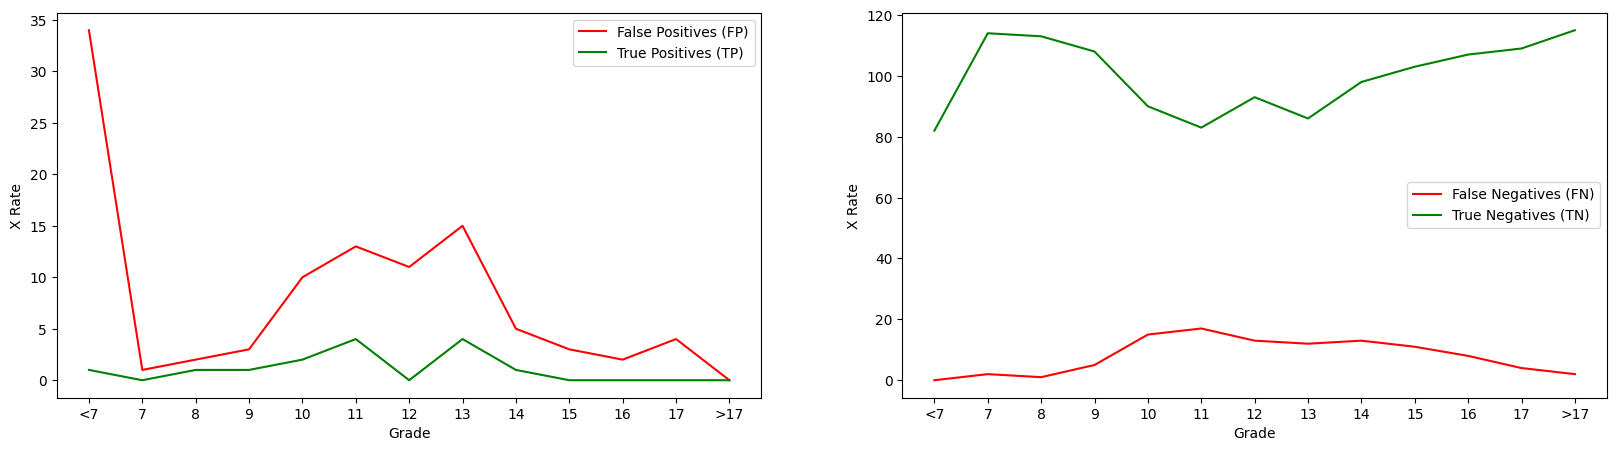

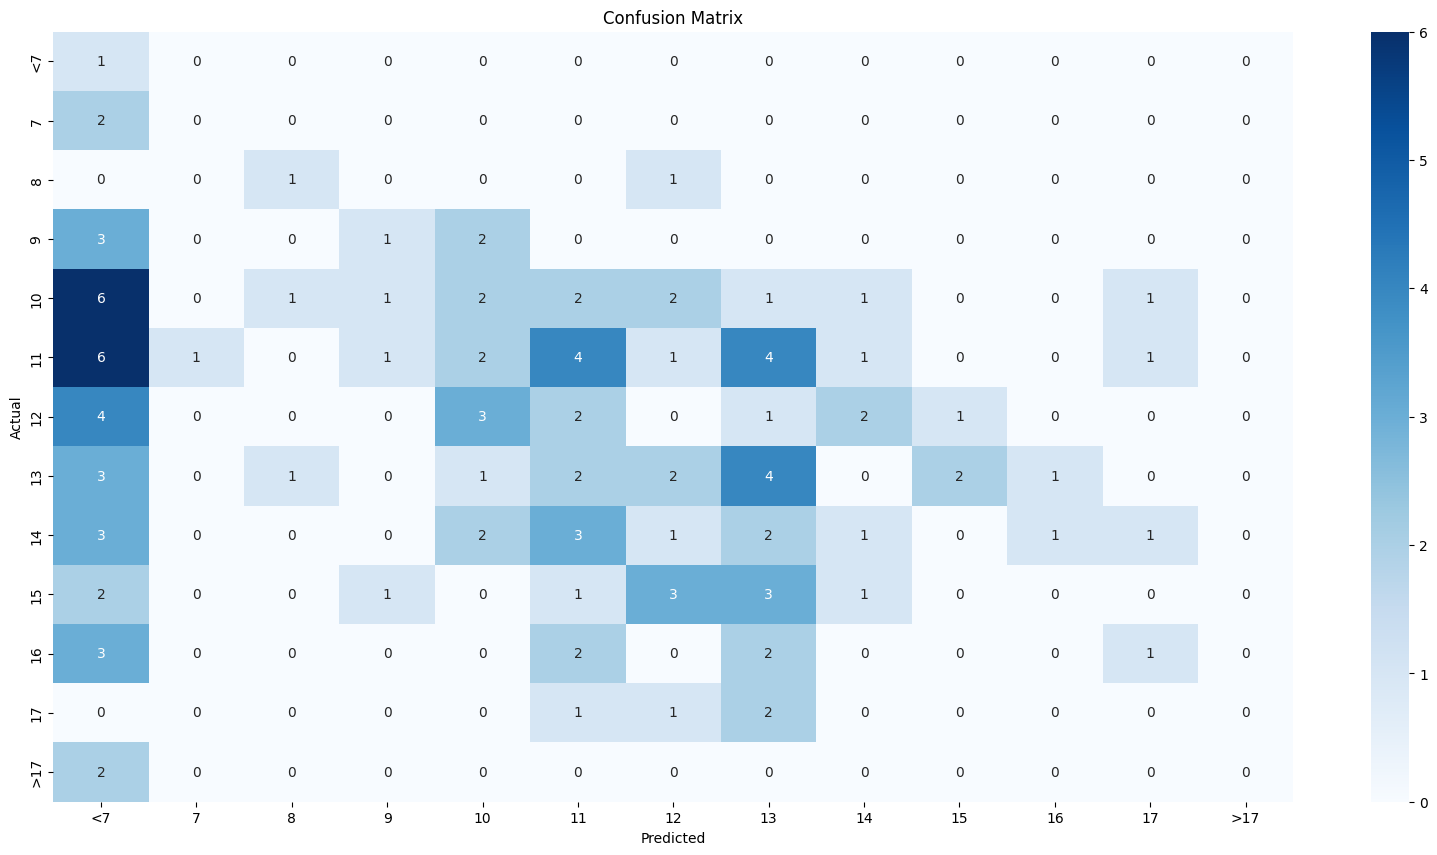

In [22]:
if not SKIP_BIG:
    normal_result = pd.read_csv(RESULT_PATH + "normal_result.csv")

    # Evaluate results
    evaluation = MultiClassEvaluation(normal_result, match='G3', is_string=True, min_grade=7, max_grade=17, offset=2)
    evaluation.print_stats()
    evaluation.plot()
    evaluation.plot_confusion_matrix()

### 5.2 Smaller Bayesian Network

In [23]:
# Create predictions

# tuned_predictions = tuned_network.predict(tuned_test, stochastic=False, n_jobs=NUMBER_CORES)
tuned_predictions = fast_prediction(tuned_network, tuned_test)
tuned_predictions.rename(columns={k: f"{k}_pred" for k in tuned_predictions.columns}, inplace=True)

# Save results for later evaluation
tuned_result = pd.concat([tuned_labels, tuned_predictions], axis=1, join='inner')
tuned_result.to_csv(RESULT_PATH + "tuned_results.csv", index=False)

Accuracy: 0.222
Mean false error: 2.62
Mean absolute error: 2.03
Precision: 0.14958719251523223
Recall: 0.2695441813088872
F1 score: 0.15996772140389165


/home/tom/projects/probability-ki/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


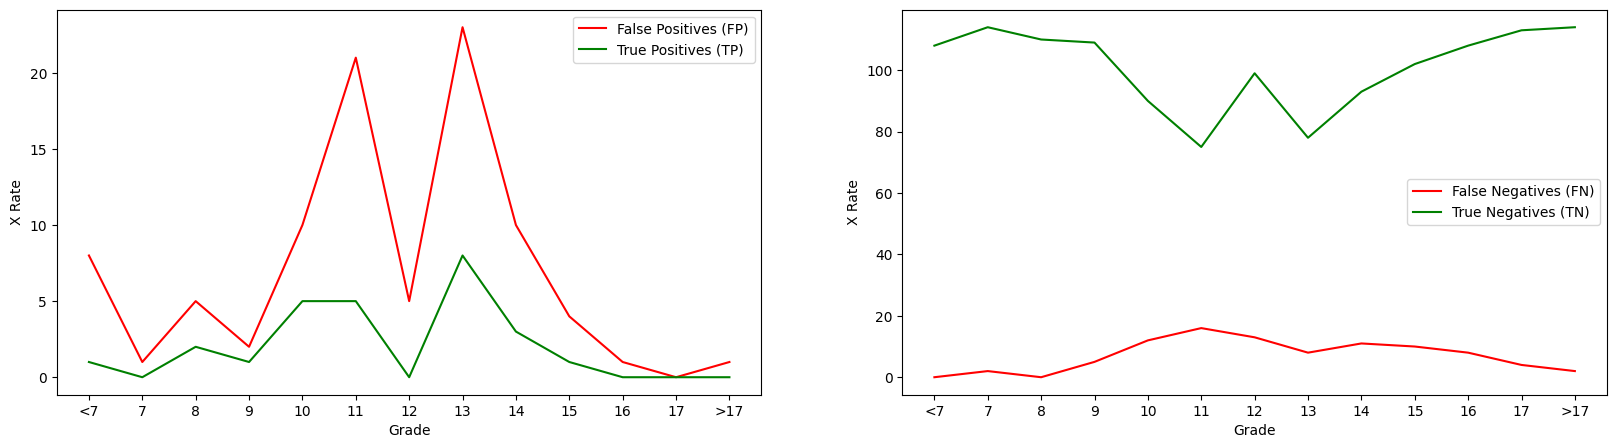

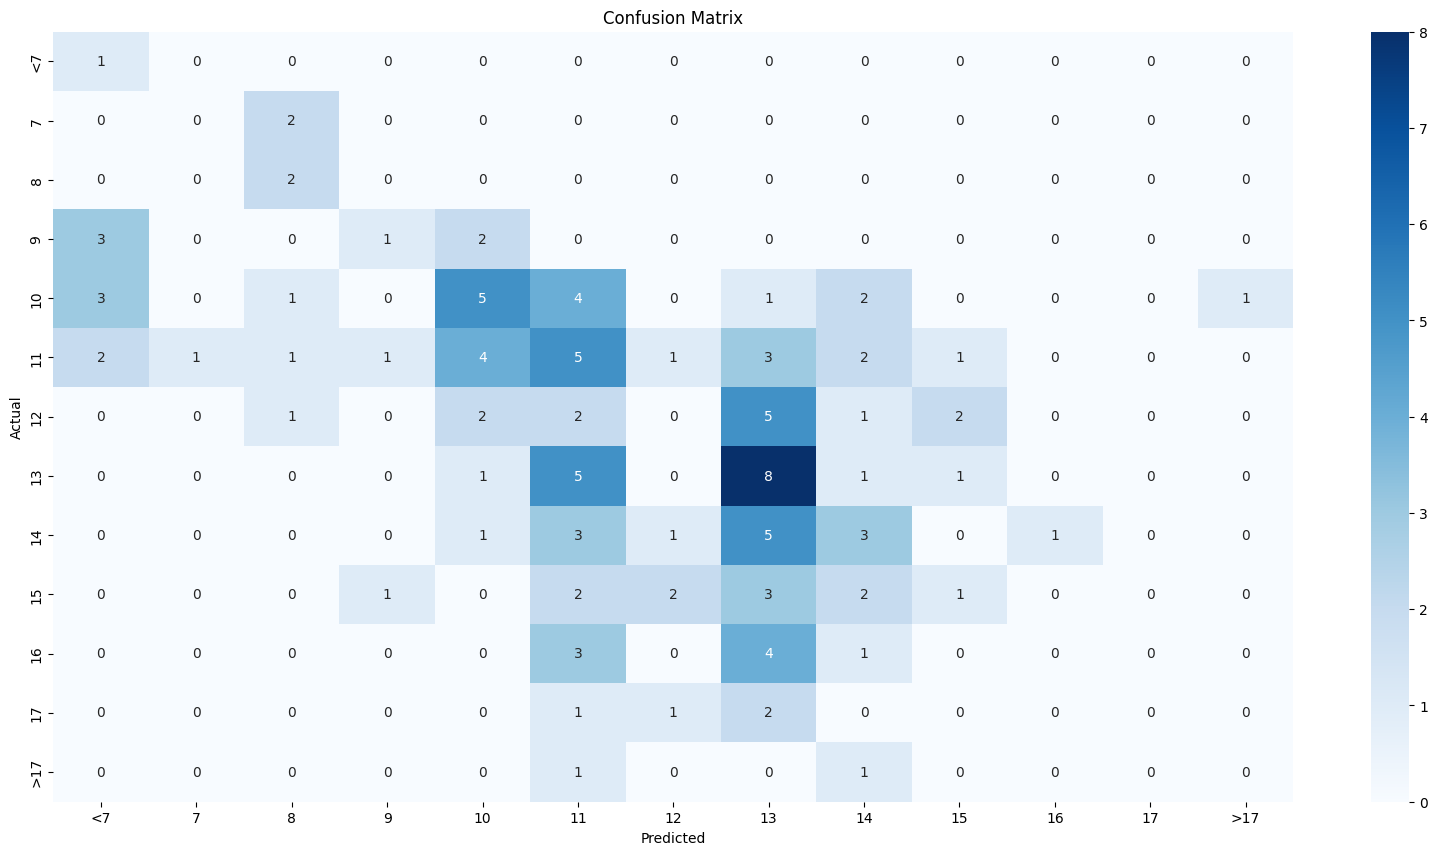

In [24]:
tuned_result = pd.read_csv(RESULT_PATH + "tuned_results.csv")

# Evaluate results
evaluation_tuned = MultiClassEvaluation(tuned_result, match='G3', is_string=True, min_grade=7, max_grade=17, offset=2)
evaluation_tuned.print_stats()
evaluation_tuned.plot()
evaluation_tuned.plot_confusion_matrix()

### 5.3 Binary Bayesian Network (Passed/Failed)
**Hint:** This network is not used in the final report and was a first approach to measure the quality.

The Bayesian Network is tested with the test data loaded in step 2. The prepared test data is used to predict the grades of the students. The results are evaluated by comparing the predicted grades with the actual grades. The evaluation is done by calculating the accuracy of the predictions and a plot of the false positive, false negative predictions, true positive and true negative predictions.

In [25]:
# Create predictions
binary_predictions = binary_network.predict(binary_test, stochastic=False, n_jobs=NUMBER_CORES)
binary_predictions.rename(columns={k: f"{k}_pred" for k in binary_predictions.columns}, inplace=True)

# Save results for later evaluation
binary_result = pd.concat([binary_labels, binary_predictions], axis=1, join='inner')
binary_result.to_csv(RESULT_PATH + "binary_results.csv", index=False)

100%|██████████| 117/117 [00:04<00:00, 28.87it/s]


Accuracy: 0.829
Mean false error: 1.0
Mean absolute error: 0.17
Precision: 0.7666548547129695
Recall: 0.8019662921348314
F1 score: 0.780570142535634


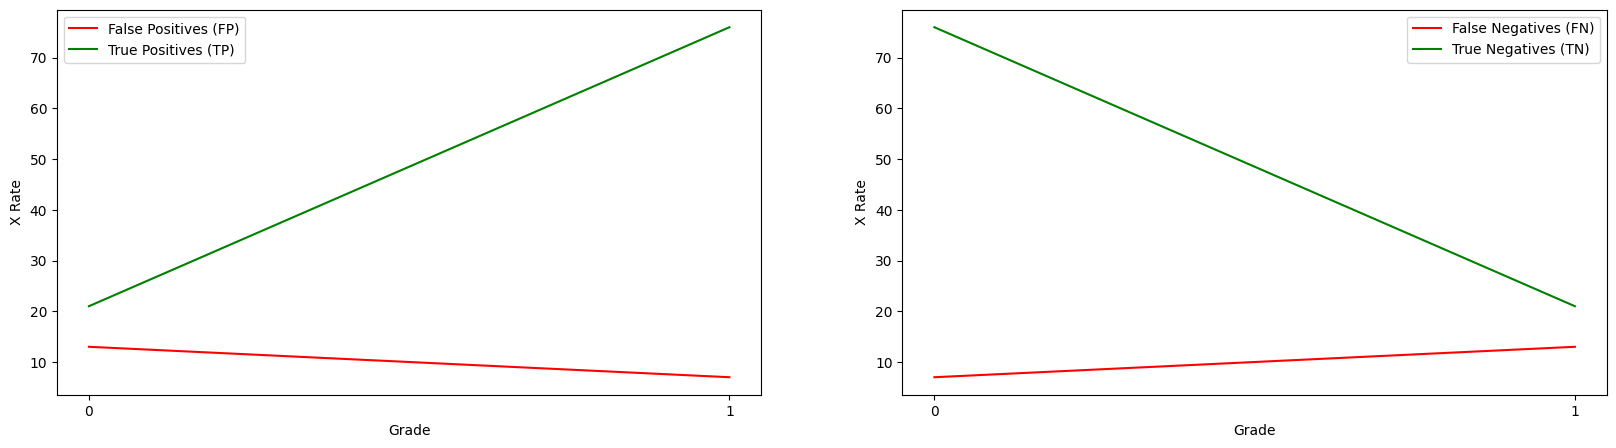

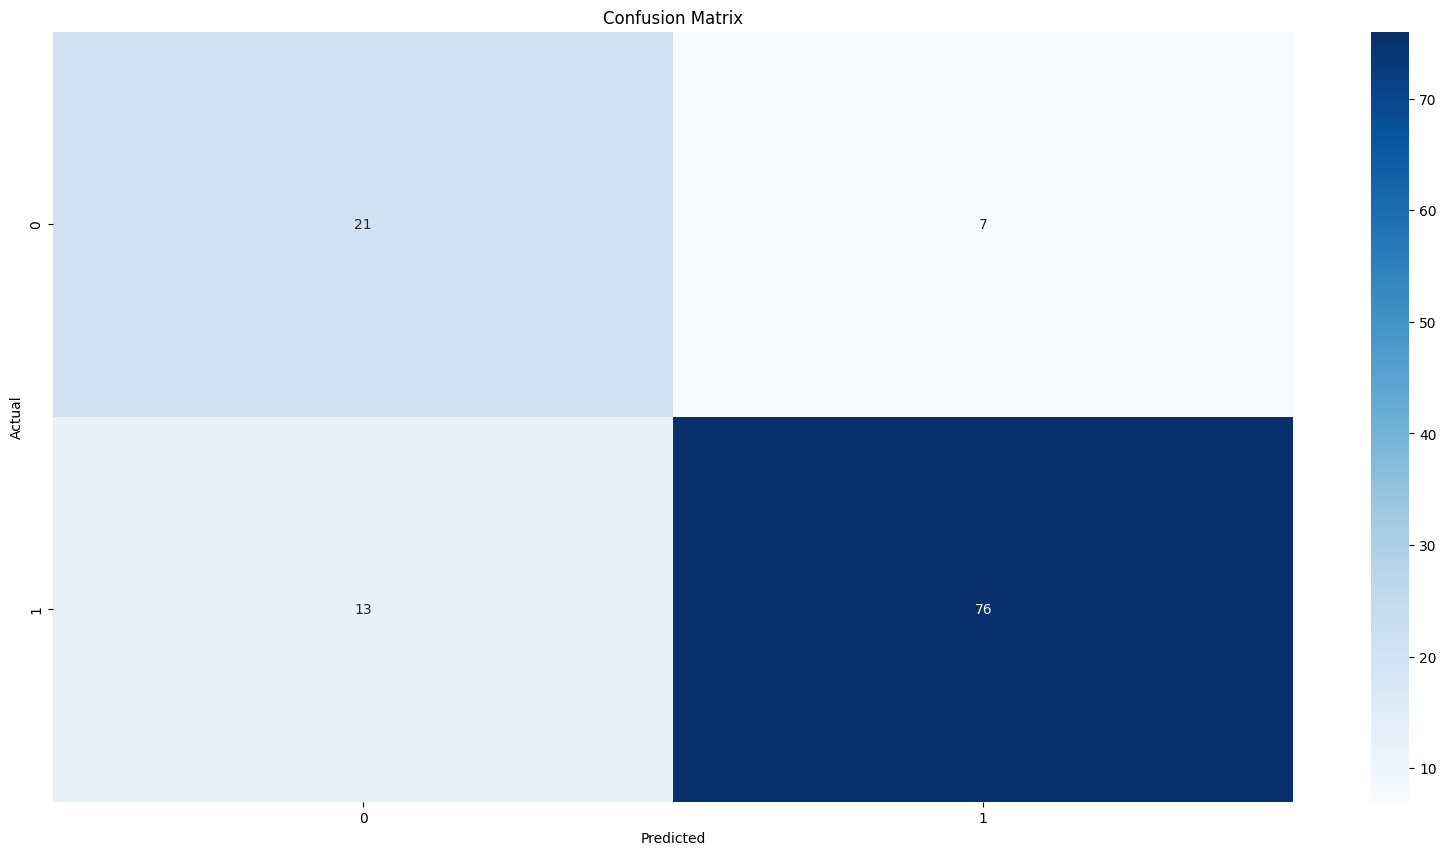

In [26]:
binary_result = pd.read_csv(RESULT_PATH + "binary_results.csv")

# Evaluate results
evaluation_binary = BinaryEvaluation(binary_result, match='G3')
evaluation_binary.print_stats()
evaluation_binary.plot()
evaluation_binary.plot_confusion_matrix()